In [10]:
from fastai.text import *
from fastai.lm_rnn import *
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd

TWEETSLM_PATH=Path('./LM_tweets')
CLAS_PATH=Path('./tweets_class')

In [11]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

F1(macro) =  0.6492548992733779
Accuracy  =  0.6746794871794872


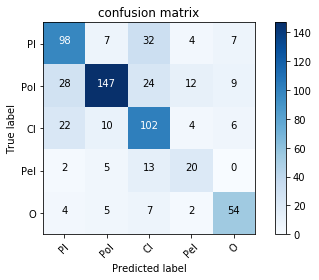

In [3]:
bs = 256
bptt,em_sz,nh,nl = 70,400,1150,3

tst_tok = np.load(CLAS_PATH/'tmp/tok_tst.npy')
tst_sent = np.load(CLAS_PATH/'tmp/tst_ids.npy')
tst_lbls = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()
tst_lbls -= tst_lbls.min()
c=int(tst_lbls.max())+1
tst_ds = TextDataset(tst_sent, tst_lbls)
tst_samp = SortSampler(tst_sent, key=lambda x: len(tst_sent[x]))
tst_lbls_sampled = tst_lbls[list(tst_samp)]
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=tst_samp)
md = ModelData(TWEETSLM_PATH, None, tst_dl)
itos = pickle.load(open(TWEETSLM_PATH/'tmp/itos.pkl', 'rb'))
vs = len(itos)
    
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
                layers=[em_sz*3, 50, c], drops=[0., 0.])

learn = RNN_Learner(md, TextModel(to_gpu(m)))
learn.load_encoder('lm1_enc')
learn.load('final')
predictions = np.argmax(learn.predict(), axis=1)

f1 = f1_score(tst_lbls_sampled, predictions, average='macro')
print('F1(macro) = ', f1)

acc = (tst_lbls_sampled == predictions).mean()
print('Accuracy  = ', acc)


cnf_matrix = confusion_matrix(tst_lbls_sampled, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PI', 'PoI', 'CI', 'PeI', 'O'], title='confusion matrix')
plt.show()

In [4]:
df = pd.DataFrame({'tokens':tst_tok, 'actual':tst_lbls , 'prediction': predictions})

In [13]:
print_full(df.loc[df['actual']!=df['prediction']])

                                                                                                                                                                                                                                                                                                                                                                                                                                                              tokens  \
1    [\n, xbos, user_ref, user_ref, user_ref, chorrada, es, vota, a, pablo, iglesias, que, apoya, a, bildu, y, los, asesinos, de, eta]                                                                                                                                                                                                                                                                                                                                 
2    [\n, xbos, rt, user_ref, .@, t_up, upyd, cree, que, el, t_up, psoe, acabará, facili

In [ ]:
print_full(df.loc[df['actual']==df['prediction']])